In [23]:
cd C:\Users\USER\Quant

C:\Users\USER\Quant


In [24]:
import Quant as Quant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

In [25]:
path = '재무데이터.xlsx'
path_price = '수정주가.csv'
path_mkt = '시총데이터.csv'
path_endmonth = '결산월.csv'
path_kospiyn = '거래소데이터.csv'
path_delist_and_stop = '상장폐지데이터.csv'

In [26]:
cleaned_data = Quant.preprocessing_path(path)
cleaned_price = Quant.preprocessing_price(path_price)
cleaned_kospiyn = Quant.preprocessing_kospiyn(path_kospiyn)
cleaned_mkt = Quant.preprocessing_mktdata(path_mkt)
delist_data, stop_data = Quant.preprocessing_stop_and_delist(path_delist_and_stop)
cleaned_endmonth = Quant.preprocessing_period(path_endmonth)

In [27]:
def price_after_delist(cleaned_price, delist_data) :
    cleaned_price2 = cleaned_price.copy()
    x1_list = delist_data.index
    x2_list = list(delist_data[delist_data.columns[0]])    
    
    lst = []
    for i in range(len(x1_list)) :
        x1, x2 = x1_list[i], x2_list[i]
        cleaned_price2[x1][x2:] = np.zeros(len(cleaned_price2[x1][x2:]))
        lst.append(cleaned_price2[x1])
    p1 = cleaned_price2[cleaned_price2.columns.difference(x1_list)]
    p2 = pd.concat(lst,axis = 1)
    p = pd.concat([p1,p2],axis = 1)
    return p[cleaned_price2.columns]

In [28]:
def preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, 
                           delist_data, stop_data) :
    extreme_return = (cleaned_price.pct_change() > 3).max(0)
    not_extreme = extreme_return[extreme_return == False].index
    P = cleaned_price[not_extreme].resample('M').last()
    STOP = stop_data['거래정지여부'].loc[not_extreme].T.resample('M').last()
    DELIST = delist_data.loc[delist_data.index.intersection(not_extreme)]
    FINANCE = cleaned_data.loc[not_extreme]
    P = price_after_delist(P, DELIST)
    MKT = cleaned_mkt[not_extreme].resample('M').last()
    return FINANCE, P, MKT, DELIST, STOP

In [29]:
def calculate_data_Q_before_2001(rebalance_day):
    if rebalance_day.month <= 5 :
        data_Q = str(rebalance_day.year - 2) + '-12-31'
    else :
        data_Q = str(rebalance_day.year - 1) + '-12-31'
    return pd.to_datetime(data_Q)

In [30]:
def calculate_data_Q_after_2001(rebalance_day):
    year = rebalance_day.year
    bQ3 = pd.to_datetime(str(year-1) + '-09-30')
    bQ4 = pd.to_datetime(str(year-1)+'-12-31')
    Q1 = pd.to_datetime(str(year)+'-03-31')
    Q2 = pd.to_datetime(str(year)+'-06-30')
    Q3 = pd.to_datetime(str(year)+'-09-30')
    bQ4_report_day = bQ4 + relativedelta(days = 121)
    Q1_report_day = Q1 + relativedelta(days = 76)
    Q2_report_day = Q2 + relativedelta(days = 76)
    Q3_report_day = Q3 + relativedelta(days = 76)
    if rebalance_day <= bQ4_report_day :
        data_Q = bQ3
    elif rebalance_day > bQ4_report_day and rebalance_day <= Q1_report_day :
        data_Q = bQ4
    elif rebalance_day > Q1_report_day and rebalance_day <= Q2_report_day :
        data_Q = Q1
    elif rebalance_day > Q2_report_day and rebalance_day <= Q3_report_day :
        data_Q = Q2
    else :        
        data_Q = Q3
    return data_Q

In [31]:
def calculate_data_Q(rebalance_day) :
    rebalance_day = pd.to_datetime(rebalance_day)
    if rebalance_day < pd.to_datetime('2001-05-01') :
        data_Q = calculate_data_Q_before_2001(rebalance_day)
    else :
        data_Q = calculate_data_Q_after_2001(rebalance_day)
    return data_Q

### 문제 6.

 문제 2에서 만든 함수를 기반으로, 다음과 같은 변수를 지정한다.  
 FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data)
 
 다음 함수는 아래 기준에 따라 today에 매매 가능한 종목들을 스크리닝하는 함수이다.
 
 def available_stock(today, FINANCE, DELIST, cleaned_kospiyn , STOP) :
 
     1. today를 기준으로 과거에 상장폐지된 종목들을 제외한 종목들을 뽑음
     
     2. today를 기준으로 코스피 시장에 거래되는 종목들
     
     3. today를 기준으로 거래정지되지 않는 종목들
     
     4. 1,2,3을 intersection
     
     return stock_index # today기준으로 투자가능한 종목들을 인덱스로 출력
     
 현재 1,2까지는 진행되었다.  3,4번을 진행하시오. my_index.difference(index2) , my_index.intersection(index2)를 활용하시오

In [32]:
#FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data)

In [33]:
def available_stock(today, FINANCE, DELIST, cleaned_kospiyn,STOP) :
    ##########################################################################
    ################ 1.이미 상장폐지된 종목들 제거하기 #######################    
    before_DELIST = DELIST[DELIST['상장폐지일자']<today].index
    not_delist = FINANCE.index.difference(before_DELIST)
    ##########################################################################
    ################ 2.오늘 KOSPI 시장에 상장된 종목만 꺼내기 ################    
    KYN = cleaned_kospiyn.resample('M').last().fillna(method = 'ffill',limit = 7)
    one_before = pd.to_datetime(today) - relativedelta(years = 1)
    today_kospiyn = KYN[one_before:today].iloc[-1]
    kospi_index = today_kospiyn[today_kospiyn == 1].index
    ##########################################################################
    ################ 3.오늘 거래정지되지 않은 종목만 꺼내기   ################   
    not_stopped = STOP[one_before:today].iloc[-1][STOP[one_before:today].iloc[-1] !=1].index
    stock_index = not_delist.intersection(kospi_index).intersection(not_stopped)
    return stock_index

 ### 문제 7.
 
 아래의 함수는 Choose_Str를 vectorize하는 과정이다. 
  
 여러 개의 날짜리스트와 data_Q_list를 넣으면 자동으로 그 날짜에 해당되는 종목이 추출되는 논리이다.
 
 rebalance_day_list = pd.to_datetime(['2005-09-30','2005-12-31','2006-03-31','2006-06-30','2006-09-30'])

data_Q_list = pd.to_datetime(['2005-06-30','2005-09-30','2005-09-30','2006-03-31','2006-06-30'])

Strategy = Quant.Value (본인이 만든 모듈명.함수)

위의 세 개의 변수와 n = 50을 넣고 vectorized_choose_str 함수를 실행해보고 왜 결과가 그렇게 나오는지 이해하시오.

In [34]:
def vectorized_choose_str(Strategy, FINANCE, MKT, PRICE, STOP, rebalance_day_list,data_Q_list,cleaned_kospiyn, DELIST, n) :

    def Choose_Str( today, data_Q , Strategy = Strategy, FINANCE = FINANCE, 
                    PRICE = PRICE, MKT = MKT,DELIST = DELIST,STOP = STOP,
                   cleaned_kospiyn =cleaned_kospiyn, n=n ) :
        
        stock_index = available_stock(today, FINANCE, DELIST, cleaned_kospiyn,STOP)
        Str_data = Strategy(cleaned_data = FINANCE.loc[stock_index] , cleaned_mkt = MKT[stock_index],
                            data_date = data_Q, today = today, 
                            n = n, cleaned_price = PRICE[stock_index])
        my_index = Str_data.index
        return my_index    
    
    return np.vectorize(Choose_Str)(rebalance_day_list, data_Q_list)

 #### 결과창

In [35]:
rebalance_day_list = pd.to_datetime(['2005-09-30','2005-12-31','2006-03-31'])
data_Q_list = pd.to_datetime(['2005-06-30','2005-09-30','2005-09-30'])
Strategy= Quant.Value
n = 50
FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data)
vectorized_choose_str(Strategy, FINANCE, MKT, PRICE, STOP, rebalance_day_list,data_Q_list,cleaned_kospiyn, DELIST, n)

array([Index(['A024890', 'A024100', 'A010960', 'A009070', 'A014590', 'A000490',
       'A003830', 'A002820', 'A005090', 'A004890', 'A025860', 'A021820',
       'A002720', 'A007980', 'A001340', 'A007280', 'A016380', 'A004820',
       'A014990', 'A006650', 'A012800', 'A003010', 'A014530', 'A002900',
       'A000500', 'A015230', 'A003070', 'A003280', 'A071090', 'A021050',
       'A004430', 'A018500', 'A001020', 'A018470', 'A006060', 'A012320',
       'A003030', 'A005800', 'A008020', 'A000850', 'A000990', 'A010660',
       'A004800', 'A008500', 'A003610', 'A005880', 'A015260', 'A000910',
       'A013360', 'A001550'],
      dtype='object'),
       Index(['A007980', 'A000490', 'A014590', 'A004060', 'A007280', 'A003490',
       'A010960', 'A021050', 'A009470', 'A018470', 'A017940', 'A004700',
       'A002200', 'A064420', 'A005030', 'A001790', 'A000700', 'A011020',
       'A002720', 'A008870', 'A023450', 'A000590', 'A005820', 'A005090',
       'A006650', 'A027740', 'A008500', 'A004090', 'A0077

 ### 다음은 백테스트를 위한 변수들의 기본 셋팅이다. 변수들을 확인하고 물음에 답하라.

In [36]:
start_day = '2004-12-31'
end_day = '2005-09-30'
number_of_stock = 200
initial_money = 10000
rebalance_freq = 3
Strategy = Quant.F_score
####################
## 함수 기본 셋팅 ##
##########################
n = number_of_stock    ### 뽑을 종목 숫자 ########    
today , end_day = pd.to_datetime(start_day), pd.to_datetime(end_day)               ##
PF_Value = pd.DataFrame([])             ## 포트폴리오 총가치를 표시할 DataFrame    ##  
#####################################################################################

KOSPIYN = cleaned_kospiyn.resample('M').last().fillna(method = 'ffill', limit = 1) 
############################################
## 리벨런스 날짜 and 재무데이터 기준 날짜 ##
##########################################################################################
rebalance_day_list = list(pd.date_range(start_day ,end_day, freq = 'M')[::rebalance_freq]) 
data_Q_list = np.vectorize(calculate_data_Q)(rebalance_day_list)
##########################################################################################
FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, 
                                                   delist_data, stop_data)
######################################################
## 리벨런스 날짜와 재무데이터 날짜에 맞게 종목 선택 ##
######################################################
choosed_stock_list = list(vectorized_choose_str(Strategy, FINANCE, MKT, PRICE, STOP, 
                                                rebalance_day_list,data_Q_list,KOSPIYN,DELIST, n))

문제 8. 이전 기 포트폴리오의 거래정지된 종목들의 총가치는 다음과 같다.

| |A013890|A000110|
|------|---|---|
| 2004-09-30|100 |50 |
| 2004-10-31|100 |50 |
| 2004-11-30|100 |50 |
| 2004-12-31|100 |50 |

리벨런싱 날짜의 총자산은 10000원이고 거래정지된 종목을 제외하면 투자가능한 금액은 9850원이다.

리벨런싱 주기는 3개월이고, 이번기에는 Quant.F_score를 통해 200종목을 뽑고 포트폴리오 가치를 구하려고 한다.

(위의 choosed_stock_list에 기본 셋팅에 되어있음)

다음 리벨런싱날짜까지의 포트폴리오 가치를 계산해주는 my_port_value 함수를 만드세요.

리벨런싱day가 2004-12-31이면 다음 리벨런싱날짜는 2005년 3월 31일 입니다.

거래정지 데이터를 모두 감안하시오.

(거래정지가 되는경우 해당 종목은 매도할 수 없습니다. 따라서 initial_value_except_stop 계산)


def my_port_value(choosed_stock_index,start_day , Before_STOP_VALUE, 
                  rebalance_freq , PRICE, initial_money,
                  initial_money_except_stop,STOP):
                  
    ############### 전략을 실행했을 때 한 기간동안 포트폴리오의 가치를 구해줍니다. ##########
    
    return Total_VALUE, Before_STOP_VALUE,initial_money , initial_money_except_stop

In [37]:
initial_money = 10000
Before_STOP_VALUE = pd.DataFrame(np.array([[100]*4,[50]*4]).T ,
                                 columns = ['A013890','A000110'],
                                 index = pd.date_range('2004-09-30','2004-12-31',freq = 'M'))
Before_STOP_VALUE.index.name =cleaned_price.index.name
initial_money_except_stop = initial_money - Before_STOP_VALUE.iloc[-1].sum()
i = 0
choosed_stock_index = choosed_stock_list[i]
start_day = rebalance_day_list[i]

In [16]:
def my_port_value(choosed_stock_index,start_day , Before_STOP_VALUE, 
                  rebalance_freq , PRICE, initial_money,
                  initial_money_except_stop,STOP):
    ##################################################################################
    ## choosed_name = 전략으로 선택된 종목중에 이전기에 거래정지된 종목이 아닌 종목 ##
    ##################################################################################
    choosed_name = choosed_stock_index.difference(Before_STOP_VALUE.columns)
    start = start_day
    end = start + pd.DateOffset(months = rebalance_freq, day = 31)
    choosed_name = PRICE[choosed_name][start:end].iloc[0].dropna().index
    #######################################################
    ## STOP_P = 이전기에 정지된 종목들의 이번기 가격     ##
    ## P = 전략으로 선택된 종목들의 가격 (0인경우 제외)  ##
    ## N = 선택된 나머지 종목 수                         ##
    #######################################################    
    STOP_P = PRICE[Before_STOP_VALUE.columns][start:end]
    P = PRICE[choosed_name][start:end]
    P_is_not_0 = P.iloc[0] != 0
    not_0 = P_is_not_0[P_is_not_0 == True].index
    P = P[not_0]
    N = len(P.columns)
    #########################################################################
    ## PF = 거래정지 안된 포트폴리오 종목들의 가치                         ##
    ## STOP_PF = 기존에 포트폴리오의 거래정지된 종목들의 시간에 따른 가치  ##
    ## Total_PF = PF, STOP_PF를 합친 포트폴리오 종목들의 가치              ##
    #########################################################################    
    PF = initial_money_except_stop * 1/N * P/P.iloc[0]
    STOP_PF = Before_STOP_VALUE.iloc[-1] * STOP_P/STOP_P.iloc[0]
    Total_PF = pd.concat([PF,STOP_PF],axis = 1)    
    #######################################################
    ## NEW_STOP_INDEX = 이번기에 새롭게 거래정지된 종목  ##
    ## Total_Value = 전체 포트폴리오 총가치              ##
    #######################################################
    S = STOP[Total_PF.columns][start: end].iloc[-1] == 1  ### Total_PF에서 end날짜에 거래 정지된 종목이 있는지 확인한다.
    NEW_STOP_INDEX = S[S == True].index                   ### Total_PF에서 end날짜에 거래정지된 항목들을 새로 저장한다.
    Total_Value = pd.Series(Total_PF.sum(1))               
    
    Before_STOP_VALUE = Total_PF[NEW_STOP_INDEX]
    
    initial_money = Total_Value.iloc[-1]
    initial_money_except_stop = initial_money - Before_STOP_VALUE.iloc[-1].sum()    
    
    return Total_Value, Before_STOP_VALUE,initial_money , initial_money_except_stop

 ### 결과창

In [17]:
Total_Value, Before_STOP_VALUE,initial_money , initial_money_except_stop = my_port_value(choosed_stock_index,start_day , Before_STOP_VALUE, 
                  rebalance_freq , PRICE, initial_money,
                  initial_money_except_stop,STOP)

 ### 문제 9.
 
 다음 기본 셋팅과 my_port_value 함수를 이용해서 start_day부터 end_day까지 전략을 백테스트하는 모형을 만드시오.

In [22]:
def backtest(Strategy , start_day, end_day, cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data,cleaned_kospiyn,
             rebalance_freq = 6, number_of_stock = 50, initial_money = 10000) :
    ###############
    ## 기본 셋팅 ##
    ##########################
    n = number_of_stock    ### 뽑을 종목 숫자 ########
    today , end_day = pd.to_datetime(start_day), pd.to_datetime(end_day)               ##
    PF_Value = pd.DataFrame([])             ## 포트폴리오 총가치를 표시할 DataFrame    ##  
    #####################################################################################
    
    KOSPIYN = cleaned_kospiyn.resample('M').last().fillna(method = 'ffill', limit = 1) 
    ############################################
    ## 리벨런스 날짜 and 재무데이터 기준 날짜 ##
    ##########################################################################################
    rebalance_day_list = list(pd.date_range(start_day ,end_day, freq = 'M')[::rebalance_freq]) 
    data_Q_list = np.vectorize(calculate_data_Q)(rebalance_day_list)
    ##########################################################################################
    FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, 
                                                       delist_data, stop_data)
    ######################################################
    ## 리벨런스 날짜와 재무데이터 날짜에 맞게 종목 선택 ##
    ######################################################
    choosed_stock_list = list(vectorized_choose_str(Strategy, FINANCE, MKT, PRICE, STOP, 
                                                    rebalance_day_list,data_Q_list,KOSPIYN,DELIST, n))
    
    Before_STOP_VALUE = pd.DataFrame([], index = [today]) ## 거래정지 종목을 표시할 DataFrame ########################
    initial_money_except_stop = initial_money -Before_STOP_VALUE.iloc[-1].sum()  ## 거래정지 제외하고 투자가치의 합 ##     
    
    for i in range(len(rebalance_day_list)) :
        choosed_stock_index = choosed_stock_list[i]
        start_day = rebalance_day_list[i]
        Total_Value, Before_STOP_VALUE,initial_money , initial_money_except_stop = my_port_value(choosed_stock_index, start_day,
                                                                                           Before_STOP_VALUE,
                                                                                           rebalance_freq, PRICE, 
                                                                                           initial_money,
                                                                                           initial_money_except_stop, STOP)
        PF_Value = pd.concat([PF_Value, Total_Value.iloc[:-1]],axis = 0)
    PF_Value.columns = ['Port_Value']
    return PF_Value.astype(np.int64)

In [21]:
start_day = '2000-06-30'
end_day = '2021-01-31'
PF = backtest(Quant.F_score , start_day, end_day, cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data,cleaned_kospiyn,
              rebalance_freq = 3, number_of_stock = 50, initial_money = 10000)

<BarContainer object of 21 artists>

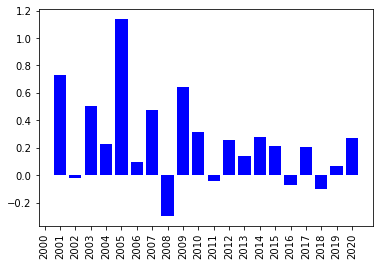

In [16]:
ind= np.arange(len(PF.resample('Y').last().pct_change()))
real_index = list(pd.Series(PF.resample('Y').last().pct_change().index).apply(lambda x : x.year))
plt.xticks(ind, real_index, rotation='vertical')
plt.bar(ind,PF.resample('Y').last().pct_change()['Port_Value'], color = 'blue')